In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


# 1. Visualize dataset
Source: https://www.kaggle.com/code/nirmalgaud/artery-segment-classification-and-stenosis-detect

In [ ]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import layers, models
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [ ]:
def load_json(json_path): # mask images were stored as json files, so we need this function to read them
    with open(json_path, 'r') as f: # open in read mode
        data = json.load(f)
    return data

In [ ]:
def create_mask(image_shape, segmentation):
    mask = np.zeros(image_shape, dtype=np.uint8) # create an empty mask filled with zeros that has the same shape as the image
    points = np.array(segmentation, dtype=np.int32).reshape(-1, 2) # convert segmentation points to numpy array and reshape
    cv2.fillPoly(mask, [points], color=255) # fill the polygon defined by the points with white color (255) - the vessel region
    return mask

In [ ]:
def visualize_segmentation(image_path, annotations, categories, image_id, image_index):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_annotations = [ann for ann in annotations if ann['image_id'] == image_id]
    mask = np.zeros_like(img, dtype=np.uint8)

    for ann in img_annotations:
        category_id = ann['category_id']
        category_name = next(cat['name'] for cat in categories if cat['id'] == category_id)
        segmentation = ann['segmentation']
        ann_mask = create_mask(img.shape, segmentation)
        mask = np.maximum(mask, ann_mask)
        img_color[ann_mask == 255] = [255, 0, 0]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"Original Image {image_index + 1}")
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Segmented Image {image_index + 1} (ID: {image_id})")
    plt.imshow(img_color)
    plt.axis('off')

    plt.show()
    return mask

Processing image: 922.png


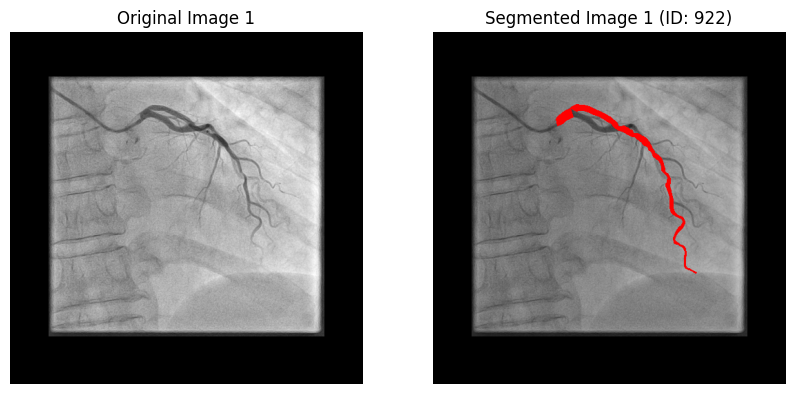

Processing image: 793.png


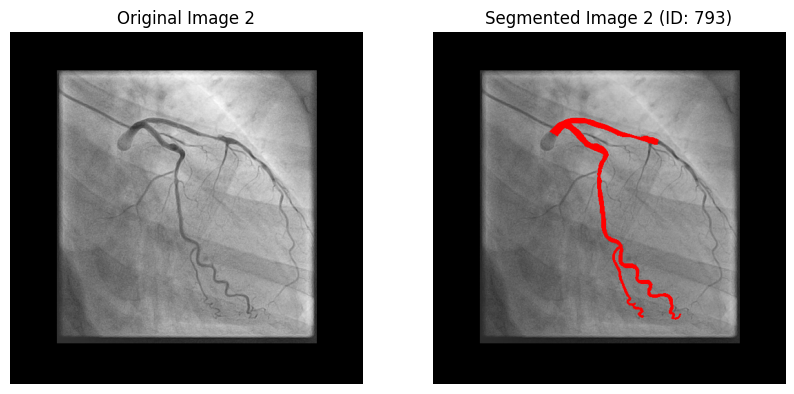

Processing image: 782.png


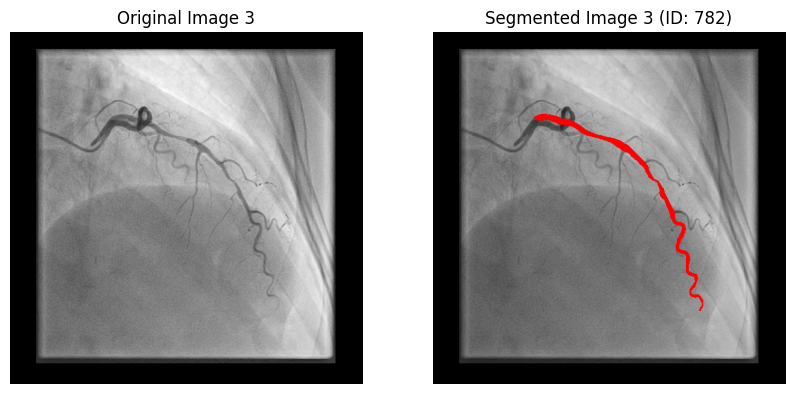

In [ ]:
def main():
    base_path = "/content/gdrive/MyDrive/EMMBIOME/SERBIA/Biomedical Imaging/Seminar Paper/ARCADE/syntax"
    train_images_path = os.path.join(base_path, "train", "images")
    train_json_path = os.path.join(base_path, "train", "annotations", "train.json")

    data = load_json(train_json_path)
    images = data['images']
    annotations = data['annotations']
    categories = data['categories']

    for idx, sample_image in enumerate(images[:3]):
        image_id = sample_image['id']
        image_file = sample_image['file_name']
        image_path = os.path.join(train_images_path, image_file)

        print(f"Processing image: {image_file}")
        visualize_segmentation(image_path, annotations, categories, image_id, idx)

if __name__ == "__main__":
    main()

# 2. Preprocessing images and preparing a dataset



In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
dataset = "/content/gdrive/MyDrive/EMMBIOME/SERBIA/Biomedical Imaging/Seminar Paper/ARCADE/syntax"
train_img_path = os.path.join(dataset, "train/images")
train_json_path = os.path.join(dataset, "train/annotations/train.json")

val_img_path = os.path.join(dataset, "val/images")
val_json_path = os.path.join(dataset, "val/annotations/val.json")

train_json = load_json(train_json_path)
val_json = load_json(val_json_path)


In [ ]:
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # read the image in grayscale mode
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT)) # resize the image to the dimensions 256x256
    image = cv2.GaussianBlur(image, (3, 3), 0) # apply Gaussian blur to reduce noise and improve contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) # create a CLAHE object with a clip limit of 2.0 and a tile grid size of 8x8
    image = clahe.apply(image) 
    image = image.astype(np.float32) / 255.0 # normalize pixel values to the range [0, 1]
    image = np.expand_dims(image, axis=-1) # add a channel dimension to the image (from (256, 256) to (256, 256, 1))
    return image

In [ ]:
def preprocess_mask(image_shape, annotations, image_id):
    mask = np.zeros(image_shape, dtype=np.uint8) # create an empty mask filled with zeros 
    for ann in annotations:
        if ann['image_id'] == image_id:
            segmentation = ann['segmentation'] # get the segmentation points for the current image
            ann_mask = create_mask(image_shape, segmentation) # create a binary mask for the current annotation
            mask = np.maximum(mask, ann_mask) # combine masks from multiple annotations by taking the maximum value at each pixel 
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT)) # resize the mask to match the dimensions 256 x 256
    mask = (mask > 0).astype(np.float32) # convert to binary mask (0 and 1) and float32 type for U-Net training
    mask = np.expand_dims(mask, axis=-1) # add channel dimension for U-Net input -> shape: (256, 256, 1)
    return mask

In [ ]:
def create_dataset(images, annotations, images_path):
    X = []
    Y = []

    for img_info in images:
        image_id = img_info['id']
        image_file = img_info['file_name']
        image_path = os.path.join(images_path, image_file)

        image = preprocess_image(image_path)
        mask = preprocess_mask(
            image_shape=cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).shape,
            annotations=annotations,
            image_id=image_id
        )

        X.append(image)
        Y.append(mask)

    return np.array(X), np.array(Y)

In [ ]:
images = train_json['images']
annotations = train_json['annotations']
X_train, Y_train = create_dataset(
    images=images,
    annotations=annotations,
    images_path=train_img_path
)


print("Images shape:", X_train.shape)
print("Masks shape:", Y_train.shape)

Images shape: (1000, 256, 256, 1)
Masks shape: (1000, 256, 256, 1)


In [ ]:
val_images = val_json['images']
val_annotations = val_json['annotations']
X_val, Y_val = create_dataset(
    images=val_images,
    annotations=val_annotations,
    images_path=val_img_path
)
print("X_val:", X_val.shape)
print("Y_val:", Y_val.shape)

X_val: (200, 256, 256, 1)
Y_val: (200, 256, 256, 1)


# 3. Training Model - UNet

Source of model: https://unicloud.kg.ac.rs/index.php/s/R6Nzi7EoxwmLFs6?dir=/Segmentation%20code

In [ ]:
def unet(input_shape=(256,256,1)):
    inputs = layers.Input(input_shape)

    # Contracting path
    c1 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.3)(p1)

    c2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.3)(p2)

    c3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.3)(p3)

    c4 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.3)(p4)


    c5 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    p5 = MaxPooling2D(pool_size=(2, 2))(c5)
    p5 = Dropout(0.3)(p5)

    c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
    c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    p6 = MaxPooling2D(pool_size=(2, 2))(c6)
    p6 = Dropout(0.3)(p6)

    # Final Layer
    c7 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p6)
    c7 = Dropout(0.3)(c7)
    c7 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)


    # Expanding path
    #512
    u8 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c6])
    c8 = Dropout(0.3)(u8)
    c8 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)


    #256
    u9 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c5])
    c9 = Dropout(0.3)(u9)
    c9 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)


    #128
    u10 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c9)
    u10 = concatenate([u10, c4])
    c10 = Dropout(0.3)(u10)
    c10 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
    c10 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)


    u11 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c10)
    u11 = concatenate([u11, c3])
    c11 = Dropout(0.3)(u11)
    c11 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
    c11 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)


    u12 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c11)
    u12 = concatenate([u12, c2])
    c12 = Dropout(0.3)(u12)
    c12 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c12)
    c12 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c12)


    u13 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c12)
    u13 = concatenate([u13, c1], axis=3)
    c13 = Dropout(0.3)(u13)
    c13 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c13)
    c13 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c13)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c13)

    return models.Model(inputs, outputs)


In [ ]:
model = unet()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │         80 │ input_layer_1[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │        584 │ conv2d_1[0][0]    │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      1,168 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d_3[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      4,640 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_5[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │     18,496 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_7[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_3[

 Total params: 7,779,241 (29.68 MB)

 Trainable params: 7,779,241 (29.68 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    verbose=1,
    epochs=50,
    batch_size=16,
    shuffle=False
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 356s 5s/step - accuracy: 0.8996 - loss: 0.3541 - val_accuracy: 0.9586 - val_loss: 0.1739
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 375s 5s/step - accuracy: 0.9629 - loss: 0.1597 - val_accuracy: 0.9586 - val_loss: 0.1490
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 343s 5s/step - accuracy: 0.9629 - loss: 0.1322 - val_accuracy: 0.9586 - val_loss: 0.1275
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 335s 5s/step - accuracy: 0.9631 - loss: 0.1101 - val_accuracy: 0.9589 - val_loss: 0.1172
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 334s 5s/step - accuracy: 0.9637 - loss: 0.0922 - val_accuracy: 0.9597 - val_loss: 0.1049
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 342s 5s/step - accuracy: 0.9650 - loss: 0.0857 - val_accuracy: 0.9624 - val_loss: 0.1004
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 376s 5s/step - accuracy: 0.9670 - loss: 0.0829 - val_accuracy: 0.9658 - val_loss: 0.1044
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 385s 5s/step - accuracy: 0.9707 - loss: 0.0763 - val_accuracy: 0.9707 - v

In [ ]:
model.save("/content/gdrive/MyDrive/EMMBIOME/SERBIA/Biomedical Imaging/Seminar Paper/ARCADE/syntax/unet.keras") #hdf5 format

In [ ]:
loaded_model = tf.keras.models.load_model("/content/gdrive/MyDrive/EMMBIOME/SERBIA/Biomedical Imaging/Seminar Paper/ARCADE/syntax/unet.keras")

In [ ]:
loaded_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │         80 │ input_layer_1[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │        584 │ conv2d_1[0][0]    │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      1,168 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d_3[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      4,640 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_5[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │     18,496 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_7[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_3[

 Total params: 23,337,725 (89.03 MB)

 Trainable params: 7,779,241 (29.68 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,558,484 (59.35 MB)

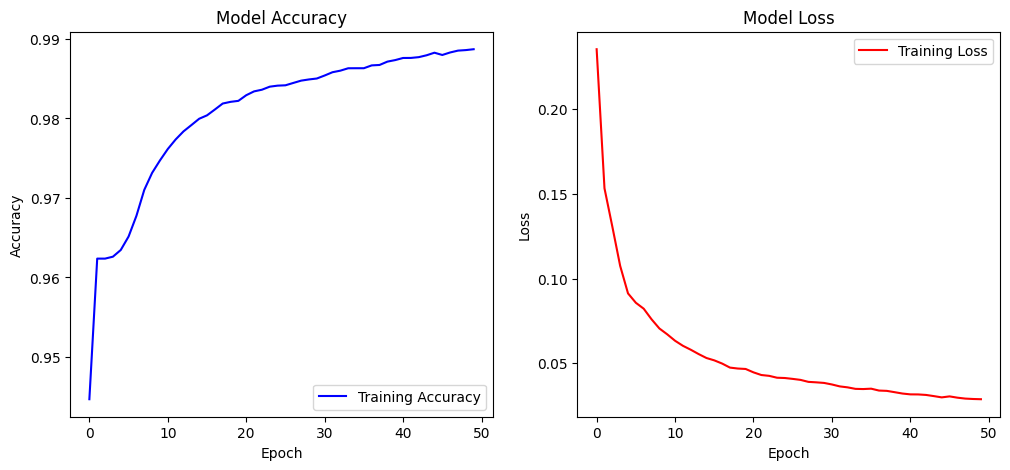

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [ ]:
test_img_path = os.path.join(dataset, "test/images")
test_json_path = os.path.join(dataset, "test/annotations/test.json")
test_json = load_json(test_json_path)

In [ ]:
test_images = test_json['images']
test_annotations = test_json['annotations']
X_test, Y_test = create_dataset(
    images=test_images,
    annotations=test_annotations,
    images_path=test_img_path
)

In [ ]:
y_pred=loaded_model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU score: ", iou_score)

10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step
IoU score:  0.5868069627645026


In [ ]:
def precision_recall_f1(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    return precision, recall, f1

metrics = [precision_recall_f1(Y_test[i], y_pred_thresholded[i])
           for i in range(len(Y_test))]

p, r, f1 = np.mean(metrics, axis=0)

print(f"Precision: {p:.4f}")
print(f"Recall:    {r:.4f}")
print(f"F1-score:  {f1:.4f}")

Precision: 0.7627
Recall:    0.7329
F1-score:  0.7350


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


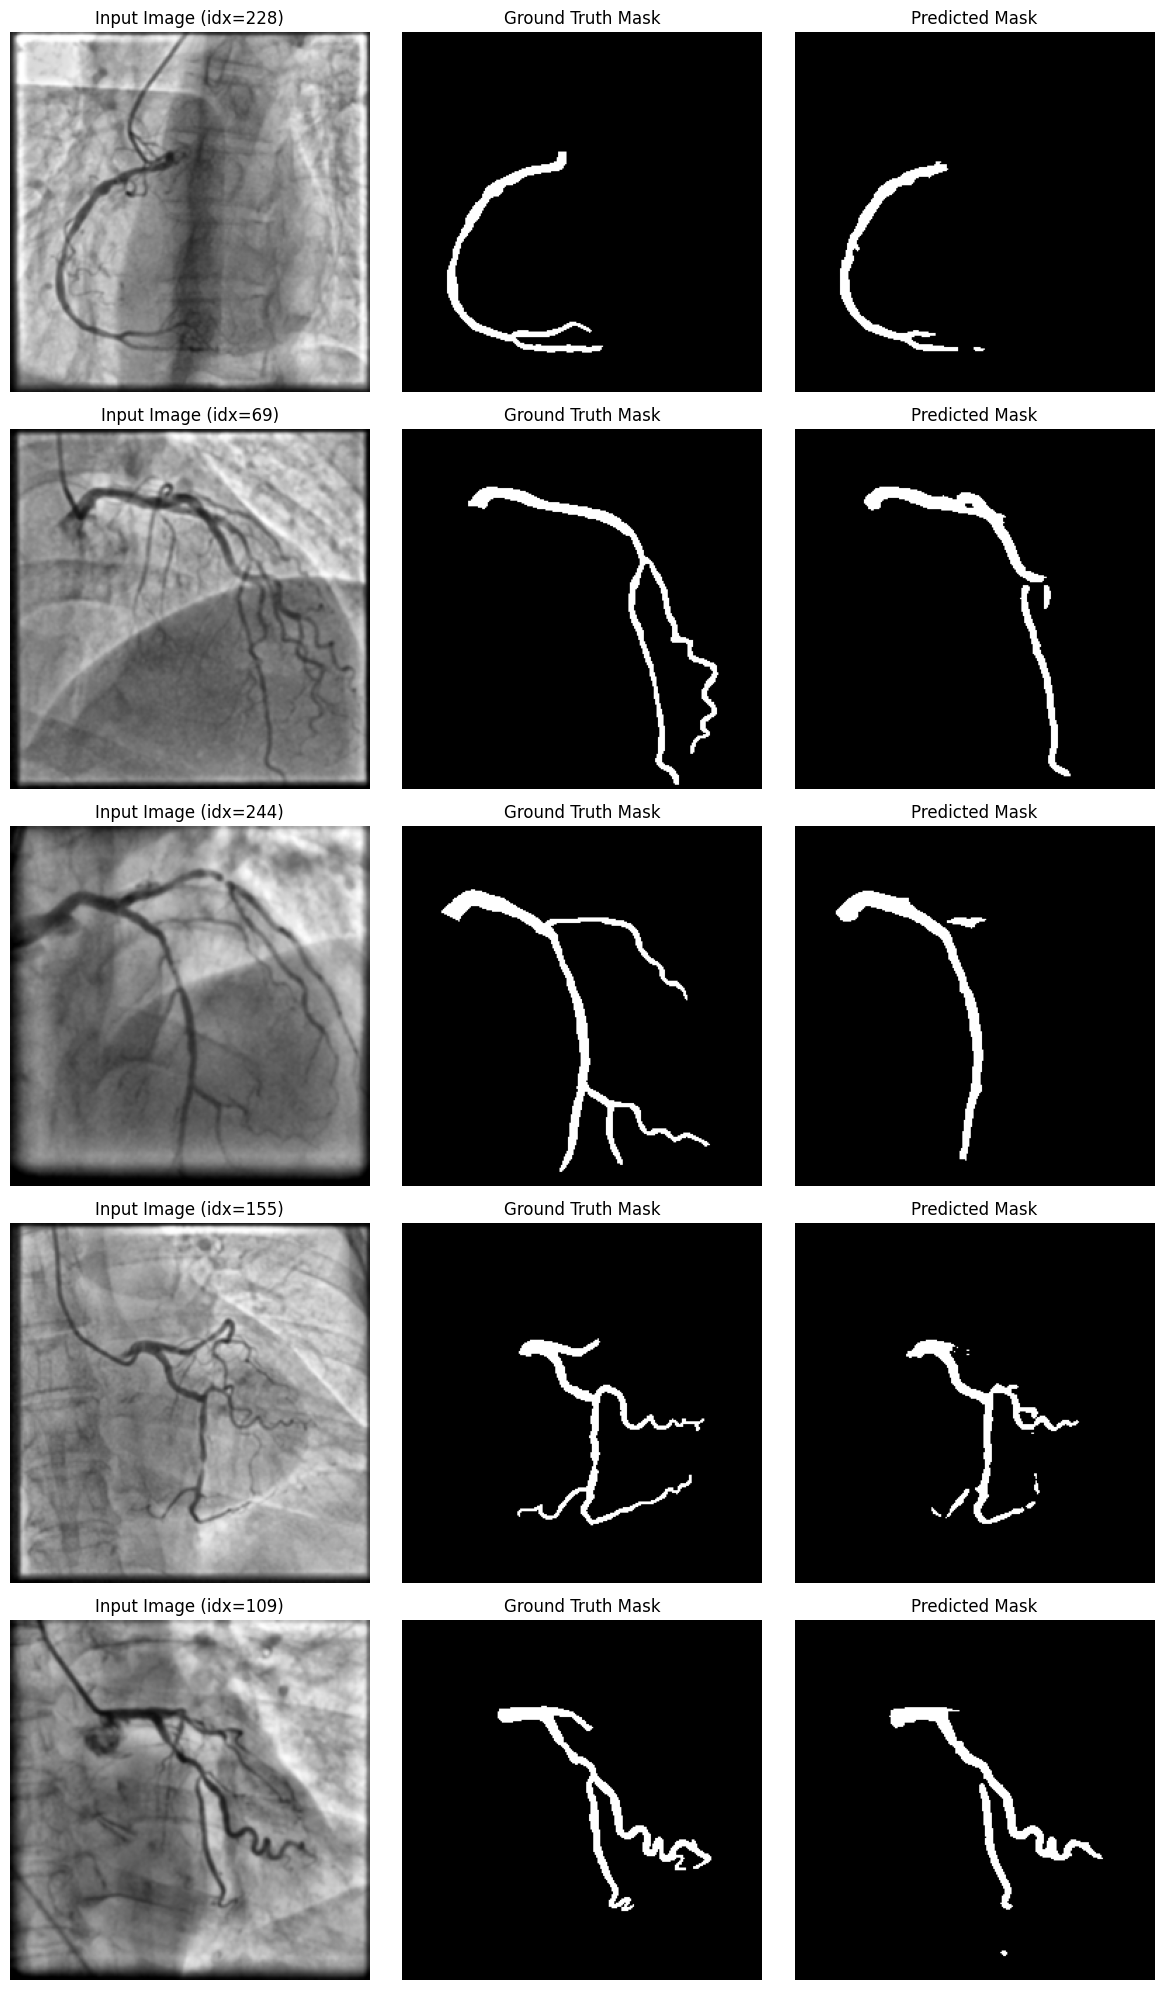

In [ ]:
import random
def visualize_random_val_predictions(model, X_val, Y_val, num_samples=5):
    indices = random.sample(range(len(X_val)), num_samples)

    plt.figure(figsize=(12, num_samples * 4))

    for i, idx in enumerate(indices):
        pred = loaded_model.predict(X_val[idx:idx+1])[0]
        pred_binary = (pred > 0.5).astype(np.float32)

        # Input image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.title(f"Input Image (idx={idx})")
        plt.imshow(X_val[idx].squeeze(), cmap='gray')
        plt.axis('off')

        # Ground truth mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.title("Ground Truth Mask")
        plt.imshow(Y_val[idx].squeeze(), cmap='gray')
        plt.axis('off')

        # Predicted mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_binary.squeeze(), cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


visualize_random_val_predictions(loaded_model, X_test, Y_test, num_samples=5)